In [1]:
import torch

torch.__version__

'2.4.0+cu124'

# 02. Neural Classification with Pytorch
classification is a problem of predicting whether something is one thing or another

## 1. Buat klasisfikasi and get it ready

In [2]:
import sklearn
sklearn.__version__

'1.5.1'

In [3]:
from sklearn.datasets import make_circles

# make 1000 sample
n_samples = 1000

# create circle
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
# print first 5 sample
print(f'5 sample pertama X:\n {X[:5]}')
print(f'5 sample pertama y:\n {y[:5]}')

5 sample pertama X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
5 sample pertama y:
 [1 1 1 1 0]


In [6]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0], 
                        "X2" : X[:, 1],
                        "Label": y})

circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


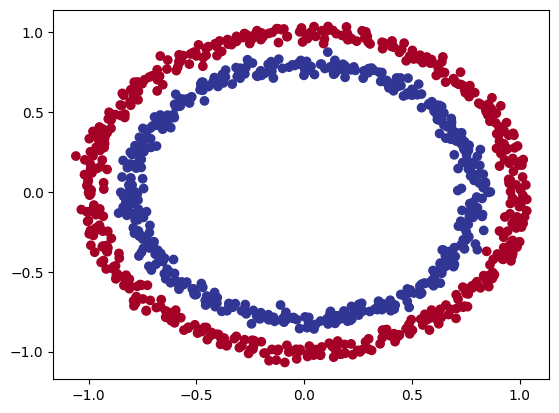

In [7]:
# visualisasi
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

data yang kita kerjakan biasanya dinamai toy data, dataset yang size nya kecil dan cukup untuk melakukan experimen tapi cukup capable untuk melatih fundamental

### 1.1 Check input dan output shape

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shape of one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape of one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensor and create train and test split

In [10]:
import torch
torch.__version__

'2.4.0+cu124'

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
# check data types
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 0.2 for 20%
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Model

bikin model untuk klasifikasi blue and red dots.

to do so, we want to:
1. Setup Device Agnostic Code, for our code to run in gpu
2. contruct a model, (subclassing `nn.Module`)
3. define loss function and optimizers
4. Create a training and test loop

In [16]:
# import pytorch and nn
import torch
from torch import nn

# buat device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

create a model that:
1. subclassses `nn.Module`
2. create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. define a `forward()`  method that outlines the forward pass
4. instantiate an instance of our model class and send it to target device

In [17]:
from sklearn import datasets

# 1. Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. create 2 nn.Linear layers capable of handling shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # input 2 layers and out 5 layer
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # input 5 and out 1 layer

    # 3. define a forward() method
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# 4. instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cuda'

In [19]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [20]:
# replikasi model diatas pakai nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}')
print(f'length of test samples: {len(X_test)}, shape: {X_test.shape}')
print(f'\nFirst 10 predictions: \n {untrained_preds[:10]}')

length of predictions: 200, shape: torch.Size([200, 1])
length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions: 
 tensor([[ 0.0083],
        [ 0.1242],
        [-0.0699],
        [ 0.0295],
        [ 0.2880],
        [ 0.3560],
        [ 0.3985],
        [ 0.4537],
        [-0.0849],
        [ 0.1359]], device='cuda:0')


### 2.1 Setup loss function

untuk regression pakai loss mae or mse (mean absolute error) or (mean square error)

untuk classification pakai binary cross entropy atau categorical cross entropy (cross entropy)

loss function mengukur seberapa salah model tersebut

untuk optimizer, yang paling sering digunakan adalah sgd dan adam

* untuk loss kita pake `torch.nn.BCEWithLogitsLoss()`
* untuk optimizer pake `torch.optim`

In [22]:
# setup loss function
loss_fn = nn.BCEWithLogitsLoss() # loss dengan sigmoid built in

# setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [23]:
# calculate accuracy - out of 100 examples what percentage we would get
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

## 3. Training a model

untuk training model, kita buat training loop 
1. forward pass
2. calculate loss
3. optimizer zero grad
4. loss backward (backprop)
5. gradient descent (optimizer step)

### 3.1 going from raw logits to -> prediction probabilities -> predictions label

output model_0 ini akan berupa sebuah logits.

kita bisa konversi logits ini ke predictions probability by passing them to somke kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass)

lalu kita bisa konversi hasil dari prediksi model kita menjadi predictions label dengan rounding them or ambil argmax() 

In [24]:
# view the first 5 outputs of the forward pass on the test data.
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0083],
        [ 0.1242],
        [-0.0699],
        [ 0.0295],
        [ 0.2880]], device='cuda:0')

In [25]:
# use the sigmoid activation on our models logits and turns them into predictions probabilities
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5021],
        [0.5310],
        [0.4825],
        [0.5074],
        [0.5715]], device='cuda:0')

In [26]:
# find the predicted labels
y_preds = torch.round(y_preds_probs)
y_preds

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.]], device='cuda:0')

In [27]:
# in full (logits -> pred probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 1.], device='cuda:0')

### 3.2 building training and test loop

more complete version

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs 
epochs = 1000

# put data into cuda
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ## training
    model_0.train()
    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    # 1.1 convert into round numbers
    # logits -> pred probs -> pred lables
    y_preds = torch.round(torch.sigmoid(y_logits))
    # 2. calculate loss / accuracy
    # im using y_logits because i'm using BCEWithLogitsLoss
    loss = loss_fn(y_logits, y_train)
    # calculate accuracy
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_preds)
    # 3. zero grad
    optimizer.zero_grad()
    # 4. backprop
    loss.backward()
    # 5. step
    optimizer.step()

    ## perform testing every 10 epoch
    if epoch % 10 == 0:
        model_0.eval()
        with torch.inference_mode():
            # 1.forward pass
            test_logits = model_0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            # 2.calculate test loss/acc
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        ## print semua info
        if epoch % 10 == 0:
            print(f'Epoch : {epoch} | Train Loss : {loss:.5f}, Train Acc : {accuracy:.2f}% | Test Loss : {test_loss:.5f}, Test Accuracy : {test_acc:.2f}%')

Epoch : 0 | Train Loss : 0.70020, Train Acc : 51.75% | Test Loss : 0.70328, Test Accuracy : 52.50%
Epoch : 10 | Train Loss : 0.69992, Train Acc : 51.50% | Test Loss : 0.70287, Test Accuracy : 52.00%
Epoch : 20 | Train Loss : 0.69967, Train Acc : 51.50% | Test Loss : 0.70249, Test Accuracy : 52.00%
Epoch : 30 | Train Loss : 0.69944, Train Acc : 51.62% | Test Loss : 0.70213, Test Accuracy : 52.50%
Epoch : 40 | Train Loss : 0.69922, Train Acc : 51.50% | Test Loss : 0.70180, Test Accuracy : 52.00%
Epoch : 50 | Train Loss : 0.69902, Train Acc : 51.25% | Test Loss : 0.70148, Test Accuracy : 52.00%
Epoch : 60 | Train Loss : 0.69883, Train Acc : 51.25% | Test Loss : 0.70119, Test Accuracy : 52.00%
Epoch : 70 | Train Loss : 0.69866, Train Acc : 51.50% | Test Loss : 0.70091, Test Accuracy : 52.00%
Epoch : 80 | Train Loss : 0.69850, Train Acc : 51.50% | Test Loss : 0.70065, Test Accuracy : 52.50%
Epoch : 90 | Train Loss : 0.69835, Train Acc : 51.88% | Test Loss : 0.70041, Test Accuracy : 52.00%
E

## 4. Make Predictions and evaluate the model

from the metrics the model is not learning anything

inspect with making predictions and visualize it

import library mrdbourke `https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py`

In [29]:
import requests
from pathlib import Path

# download helper functions from github
if Path('helper_functions.py').is_file():
    print('helper_functions.py sudah ada, skipping download')
else:
    print('downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

helper_functions.py sudah ada, skipping download


In [30]:
from helper_functions import plot_predictions, plot_decision_boundary

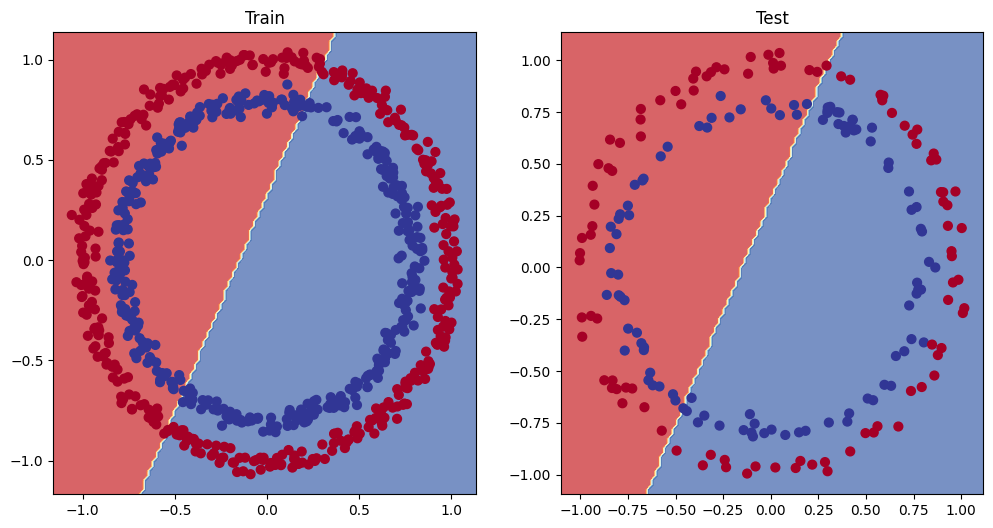

In [31]:
# plot decission boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* add more layers - give the model more chances to learn more patterns in the data
* add more hidden units - go from 5 hidden units to 10 hidden units
* fit for longger
* changing the activation functions
* change the learning rate
* change the loss function

opsi ini adalah dari perspektif model because they deal directly with the model, rather that a data.

mari coba improve model by:
* adding more hidden units : 5 -> 10
* increase the number of layers: 2 -> 3
* increase the number of epochs: 100 -> 1000

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        return self.layer3(self.layer2(self.layer1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# create a loss function
loss_fn1 = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer1 = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [34]:
# write training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# send data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# set number of epochs
epochs = 1000

for epoch in range(epochs):
    model_1.train()
    # 1. forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # 2. calculate loss/acc
    loss = loss_fn1(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # 3. zero grad
    optimizer1.zero_grad()
    # 4. backprop
    loss.backward()
    # 5. step
    optimizer1.step()
    
    ## perform testing every 10 epoch
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. calculate test loss/acc
        test_loss = loss_fn1(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    # print semua info
    if epoch % 100 == 0:
        print(f'Epoch : {epoch} | Train Loss : {loss:.5f}, Train Acc : {accuracy:.2f}% | Test Loss : {test_loss:.5f}, Test Accuracy : {test_acc:.2f}%')

Epoch : 0 | Train Loss : 0.69396, Train Acc : 50.88% | Test Loss : 0.69261, Test Accuracy : 51.00%
Epoch : 100 | Train Loss : 0.69369, Train Acc : 50.25% | Test Loss : 0.69269, Test Accuracy : 50.00%
Epoch : 200 | Train Loss : 0.69351, Train Acc : 50.12% | Test Loss : 0.69282, Test Accuracy : 49.50%
Epoch : 300 | Train Loss : 0.69339, Train Acc : 50.50% | Test Loss : 0.69295, Test Accuracy : 49.00%
Epoch : 400 | Train Loss : 0.69329, Train Acc : 50.38% | Test Loss : 0.69309, Test Accuracy : 48.50%
Epoch : 500 | Train Loss : 0.69322, Train Acc : 49.88% | Test Loss : 0.69322, Test Accuracy : 49.50%
Epoch : 600 | Train Loss : 0.69317, Train Acc : 49.50% | Test Loss : 0.69335, Test Accuracy : 53.00%
Epoch : 700 | Train Loss : 0.69313, Train Acc : 49.38% | Test Loss : 0.69347, Test Accuracy : 50.50%
Epoch : 800 | Train Loss : 0.69309, Train Acc : 50.00% | Test Loss : 0.69358, Test Accuracy : 51.00%
Epoch : 900 | Train Loss : 0.69307, Train Acc : 50.62% | Test Loss : 0.69368, Test Accuracy :

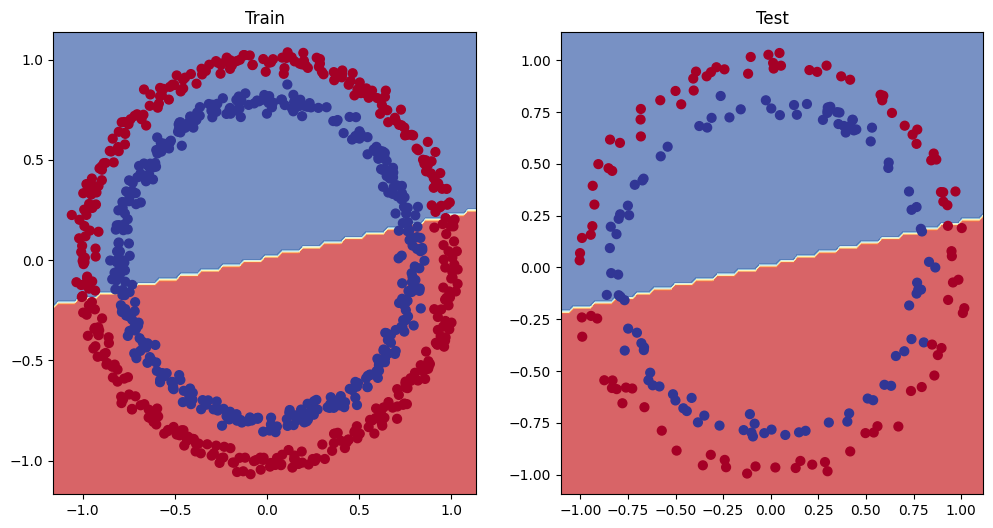

In [35]:
# plot decission boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 preparing data to see if our model can fit in a straight line

one way to troubleshoot to a larger problem is to test out a smaller problem

In [36]:
# Create some data (same as notebook 01)

weight = 0.7
bias = 0.3

start = 0
end = 1 

step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# check the data
print(len(X_regression))
X_regression[:10], y_regression[:10]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [37]:
# create train and test split

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:] 

# check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

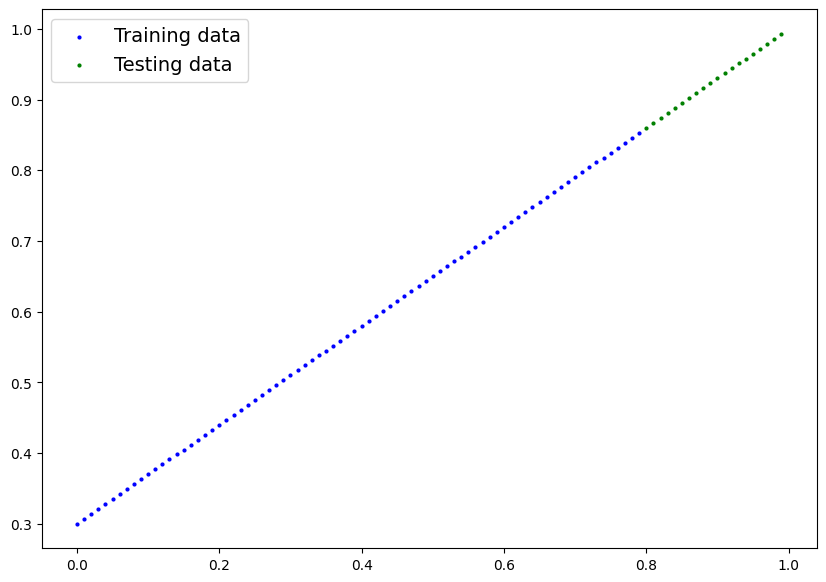

In [38]:
from helper_functions import plot_predictions

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting model_1 to fit straight line data


In [39]:
# same architecture as model_1 but with nn.Sequential
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
# loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [41]:
# train a model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epochs
epochs = 1000

# put data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# training
for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
        
    # print out whats happening
    if epoch % 100 == 0:
        print(f'Epoch : {epoch} | Train Loss : {loss:.5f}, Test Loss : {test_loss:.5f}')


Epoch : 0 | Train Loss : 0.75986, Test Loss : 0.91103
Epoch : 100 | Train Loss : 0.02858, Test Loss : 0.00081
Epoch : 200 | Train Loss : 0.02533, Test Loss : 0.00209
Epoch : 300 | Train Loss : 0.02137, Test Loss : 0.00305
Epoch : 400 | Train Loss : 0.01964, Test Loss : 0.00341
Epoch : 500 | Train Loss : 0.01940, Test Loss : 0.00387
Epoch : 600 | Train Loss : 0.01903, Test Loss : 0.00379
Epoch : 700 | Train Loss : 0.01878, Test Loss : 0.00381
Epoch : 800 | Train Loss : 0.01840, Test Loss : 0.00329
Epoch : 900 | Train Loss : 0.01798, Test Loss : 0.00360


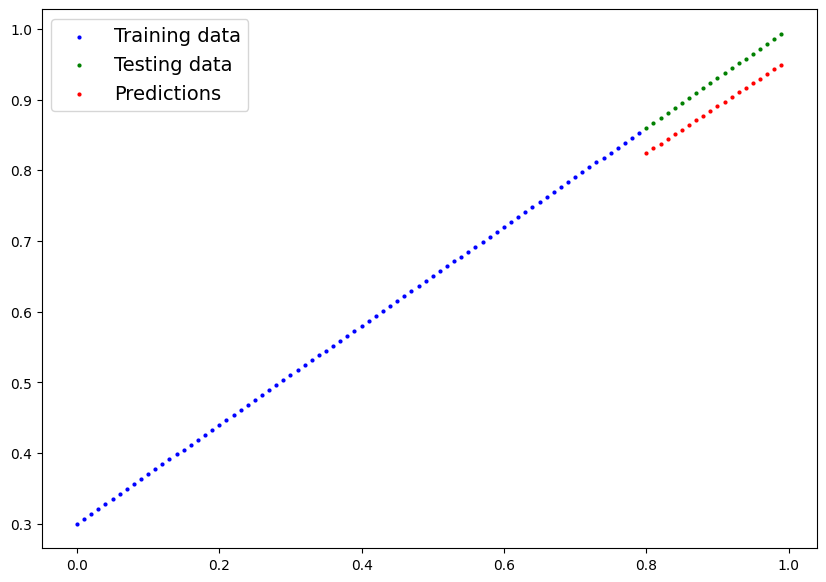

In [42]:
# turn on evaluation mode
model_2.eval()

# make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
    
plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. the missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

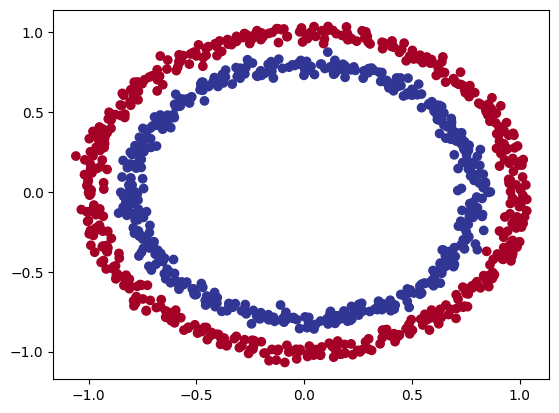

In [43]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [44]:
# convert to train and test
import torch
from sklearn.model_selection import train_test_split

# turn data into tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42) 

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* linear = straight lines
* non-linear = non-straight lines

In [45]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=32)
    self.layer_2 = nn.Linear(in_features=32, out_features=64)
    self.layer_3 = nn.Linear(in_features=64, out_features=128)
    self.layer_4 = nn.Linear(in_features=128, out_features=10)
    self.layer_5 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function
    
  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=10, bias=True)
  (layer_5): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### 6.3 Training Loop and Testing

In [46]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), 
                            lr=0.2)

In [47]:
len(X_test), len(y_test)

(200, 200)

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs 
epochs = 1000

# put data into cuda
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ## training
    model_3.train()
    # 1. forward pass
    y_logits = model_3(X_train).squeeze()
    # 1.1 convert into round numbers
    # logits -> pred probs -> pred lables
    y_preds = torch.round(torch.sigmoid(y_logits))
    # 2. calculate loss / accuracy
    # im using y_logits because i'm using BCEWithLogitsLoss
    loss = loss_fn(y_logits, y_train)
    # calculate accuracy
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_preds)
    # 3. zero grad
    optimizer.zero_grad()
    # 4. backprop
    loss.backward()
    # 5. step
    optimizer.step()

    ## perform testing every 10 epoch
    if epoch % 10 == 0:
        model_3.eval()
        with torch.inference_mode():
            # 1.forward pass
            test_logits = model_3(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            # 2.calculate test loss/acc
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        ## print semua info
        if epoch % 10 == 0:
            print(f'Epoch : {epoch} | Train Loss : {loss:.5f}, Train Acc : {accuracy:.2f}% | Test Loss : {test_loss:.5f}, Test Accuracy : {test_acc:.2f}%')

Epoch : 0 | Train Loss : 0.69343, Train Acc : 50.00% | Test Loss : 0.69323, Test Accuracy : 50.00%
Epoch : 10 | Train Loss : 0.69313, Train Acc : 50.00% | Test Loss : 0.69299, Test Accuracy : 50.00%
Epoch : 20 | Train Loss : 0.69296, Train Acc : 50.00% | Test Loss : 0.69277, Test Accuracy : 50.00%
Epoch : 30 | Train Loss : 0.69288, Train Acc : 50.00% | Test Loss : 0.69271, Test Accuracy : 50.00%
Epoch : 40 | Train Loss : 0.69282, Train Acc : 46.00% | Test Loss : 0.69266, Test Accuracy : 45.00%
Epoch : 50 | Train Loss : 0.69276, Train Acc : 50.75% | Test Loss : 0.69261, Test Accuracy : 54.50%
Epoch : 60 | Train Loss : 0.69268, Train Acc : 52.38% | Test Loss : 0.69253, Test Accuracy : 54.50%
Epoch : 70 | Train Loss : 0.69260, Train Acc : 53.50% | Test Loss : 0.69246, Test Accuracy : 55.00%
Epoch : 80 | Train Loss : 0.69252, Train Acc : 55.50% | Test Loss : 0.69239, Test Accuracy : 59.00%
Epoch : 90 | Train Loss : 0.69245, Train Acc : 56.75% | Test Loss : 0.69232, Test Accuracy : 58.50%
E

### 6.4 Evaluating a model trained with non-linear activation

In [49]:
# make prediction
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

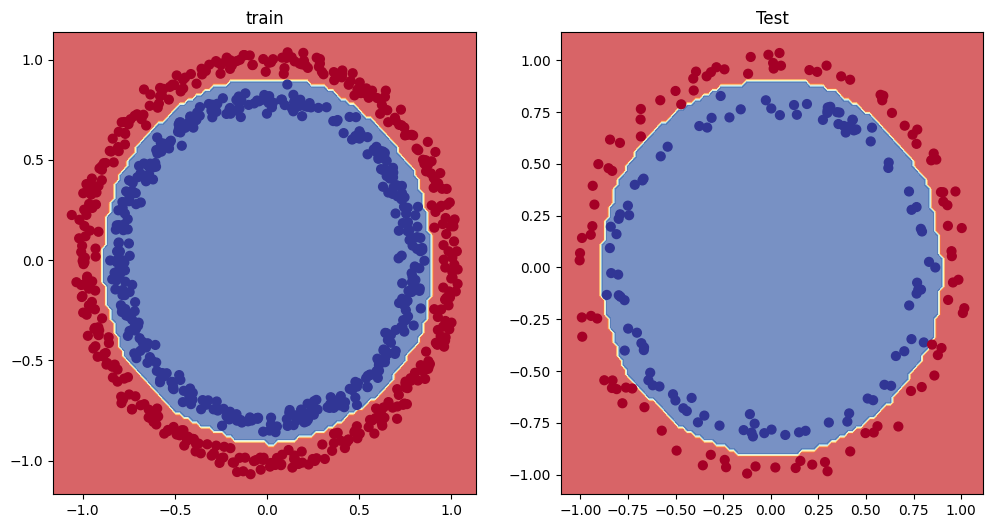

In [50]:
# plot decisionboundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non linear activation function

give the tools to computer to learn patterns

toolsnya adalah linear dan non-linear functions

In [51]:
# create tensor
A = torch.arange(-10, 10, 1, dtype=torch.float)
A.dtype, A

(torch.float32,
 tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]))

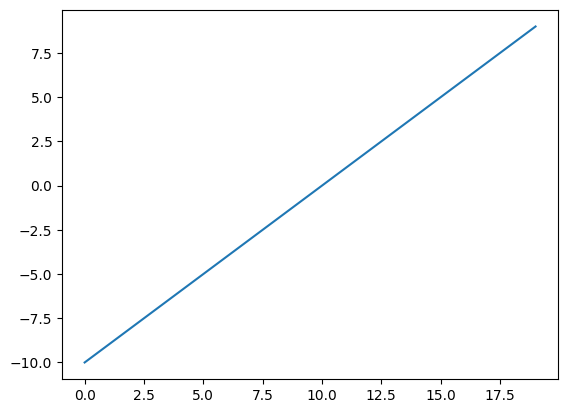

In [52]:
# visualize
plt.plot(A)

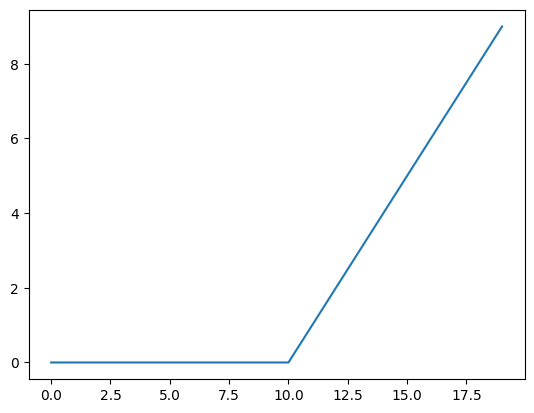

In [53]:
# plot tensor A with RelU Activation
plt.plot(torch.relu(A))

In [54]:
# replikasi relu

def relu(x:torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

A, relu(A)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
         8., 9.]))

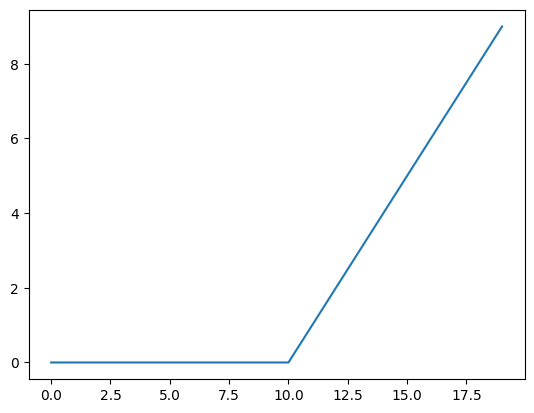

In [55]:
# plot relu activation function
plt.plot(relu(A))

In [56]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

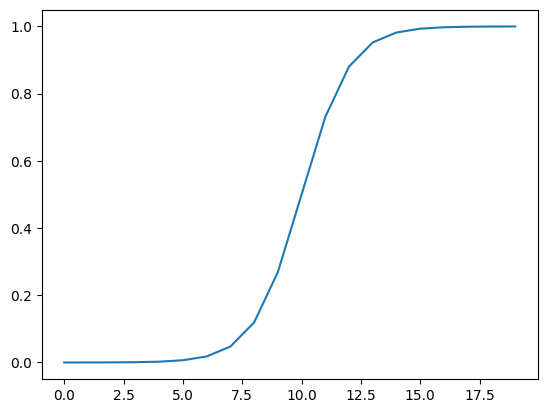

In [57]:
plt.plot(torch.sigmoid(A))

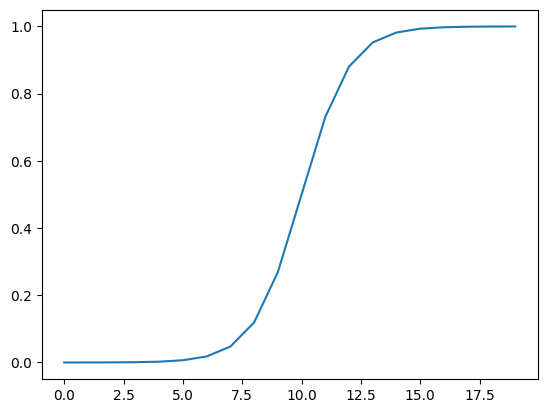

In [58]:
plt.plot(sigmoid(A))

## 8. Putting it all together with multi-class classification

* binary classification = one thing or another
* multiclass classification = more than one thing or another (cat vs dog vs chicken)


### 8.1 creating a toy multification dataset

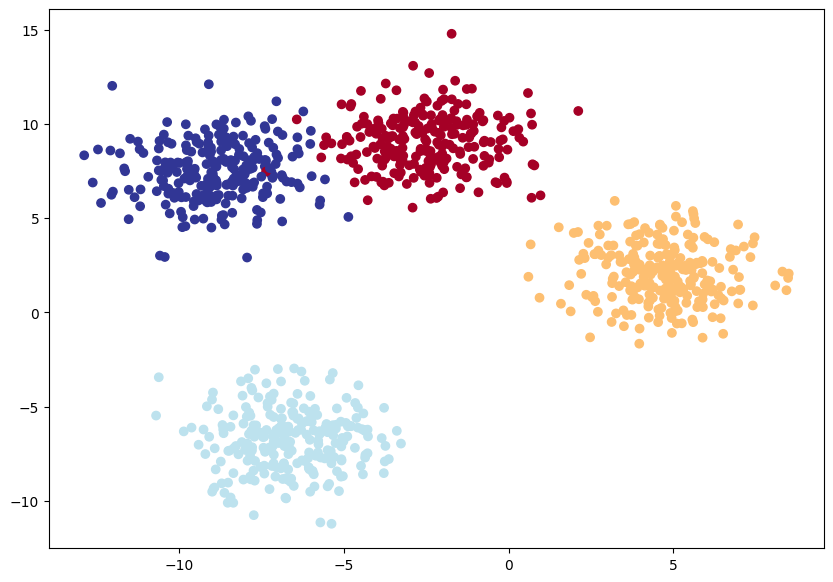

In [70]:
# import depedencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1.create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the cluster a shake up
                            random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3.split into train and test set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)

# 4.plot the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

create a model for multi class classification 4 classes

In [71]:
# create device agnostic code, best practices is to use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [147]:
# build multi class classification model

import torch
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """Inilize multi-class classification model
        
        Args:
            input_features (int): number of input features
            output_features (int): number of output features (number of output classes)
            hidden_units (int): number of hidden units in the model, default = 8
            
        Returns:
            Returns an instance of BlobModel with Sequential linear layer stack
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            # nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# create an instance of blob model
model_4 = BlobModel(input_features=2, 
                    output_features=4,
                    hidden_units=128).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [148]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='cuda:0'))

### 8.3 create a loss function and optimizer

In [149]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### 8.4 Getting predictions probabilities for a multi-class classification

in order to evaluate and train and test our model, we need to convert our model outputs (logits) to prediction probabilities and then to prediction labels

logits -> pred probs -> pred labels

In [143]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[ 0.1930,  0.2116, -0.0603,  0.0682],
        [-0.3708,  1.2668,  0.4038,  0.1531],
        [-1.0337,  0.8667, -0.5064, -0.1337],
        [ 0.0367,  0.0696, -0.1717,  0.1688],
        [ 0.2726,  0.8011,  0.1998, -0.4631],
        [-0.4457,  1.5042,  0.4962,  0.2082],
        [-1.0437,  0.8548, -0.6550, -0.1760],
        [ 0.0289,  0.8155,  0.2394, -0.3211],
        [-1.1302,  1.0847, -0.4802, -0.1261],
        [ 0.1217,  0.7800,  0.2239, -0.3796]], device='cuda:0')

In [144]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [145]:
# conver our model logits output into prediction probabilities
y_preds_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_preds_probs[:5])

tensor([[ 0.1930,  0.2116, -0.0603,  0.0682],
        [-0.3708,  1.2668,  0.4038,  0.1531],
        [-1.0337,  0.8667, -0.5064, -0.1337],
        [ 0.0367,  0.0696, -0.1717,  0.1688],
        [ 0.2726,  0.8011,  0.1998, -0.4631]], device='cuda:0')
tensor([[0.2719, 0.2770, 0.2111, 0.2400],
        [0.1000, 0.5142, 0.2170, 0.1688],
        [0.0844, 0.5648, 0.1431, 0.2077],
        [0.2509, 0.2592, 0.2036, 0.2863],
        [0.2436, 0.4132, 0.2265, 0.1167]], device='cuda:0')


### 8.5 create a training loop and testing loop for a multi class classification model

In [150]:
# set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epochs
epochs = 100

# send data to device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

## training loop

for epoch in range(epochs):
    model_4.train()
    # forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # calculate loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    # zero grad
    optimizer.zero_grad()
    # backward
    loss.backward()
    # step
    optimizer.step()
    
    ## testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}| Accuracy: {acc:.2f}% | Loss: {loss:.5f} | Test Accuracy: {test_acc:.2f}% |Test loss: {test_loss:.5f}")

Epoch: 0| Accuracy: 6.12% | Loss: 1.68255 | Test Accuracy: 92.00% |Test loss: 0.40663
Epoch: 10| Accuracy: 99.12% | Loss: 0.08204 | Test Accuracy: 99.50% |Test loss: 0.07011
Epoch: 20| Accuracy: 99.12% | Loss: 0.04825 | Test Accuracy: 99.50% |Test loss: 0.04073
Epoch: 30| Accuracy: 99.12% | Loss: 0.03963 | Test Accuracy: 99.50% |Test loss: 0.03200
Epoch: 40| Accuracy: 99.12% | Loss: 0.03548 | Test Accuracy: 99.50% |Test loss: 0.02754
Epoch: 50| Accuracy: 99.12% | Loss: 0.03303 | Test Accuracy: 99.50% |Test loss: 0.02479
Epoch: 60| Accuracy: 99.12% | Loss: 0.03140 | Test Accuracy: 99.50% |Test loss: 0.02291
Epoch: 70| Accuracy: 99.12% | Loss: 0.03022 | Test Accuracy: 99.50% |Test loss: 0.02153
Epoch: 80| Accuracy: 99.12% | Loss: 0.02934 | Test Accuracy: 99.50% |Test loss: 0.02045
Epoch: 90| Accuracy: 99.12% | Loss: 0.02865 | Test Accuracy: 99.50% |Test loss: 0.01960


In [151]:
# print predictions
model_4.eval()
with torch.inference_mode():
    y_preds = model_4(X_blob_test).squeeze().argmax(dim=1)
    
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

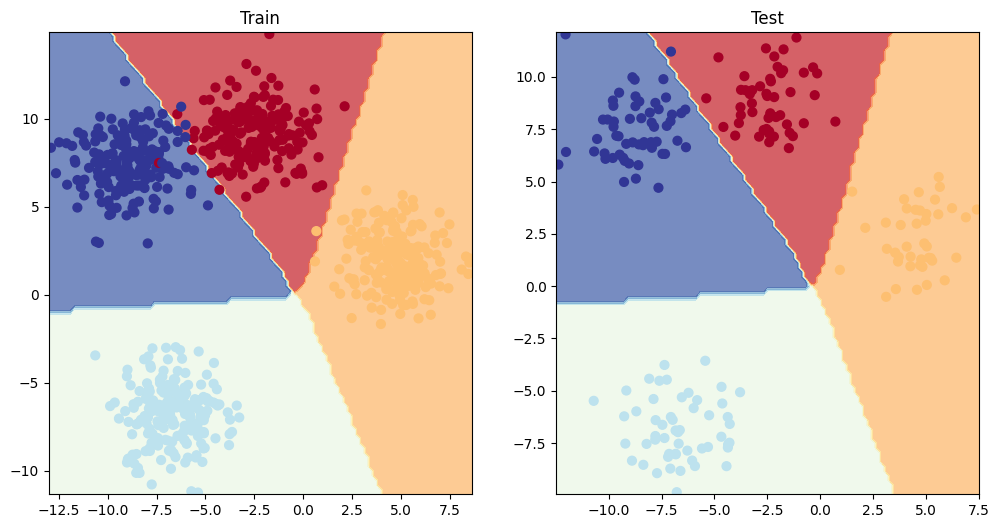

In [153]:
# plot
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model=model_4, X=X_blob_train, y=y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model=model_4, X=X_blob_test, y=y_blob_test)

## 9. A few more classification metrics to evaluate our model

* accuracy - out of 100 samples how many does our model get?
* precision
* recall
* f1 score
* confusion matrix
* classification report

###